Filename (no extensions!) Phase_Data/Run14_40


----------------------------------------------------------
First Background Parameters: [Mx Bx] [My By] =  [-1.27292569e-07  2.84777377e-04] [-6.92207018e-08  1.58114898e-04]
Second Background Parameters: [Mx Bx] [My By] =  [-1.14624466e-07  2.57339037e-04] [-4.33030586e-08  9.21919355e-05]
----------------------------------------------------------------------------//
Resonances Found:  1
UNFIT data:


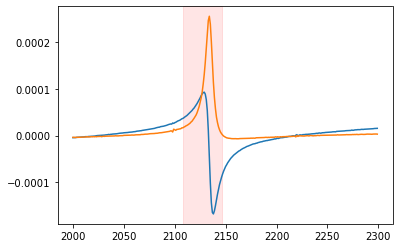

----------------------------------------------------------------------------//
ERROR - DAMPING NEGATIVE: Fitting has failed to produce realistic results
ERROR - DAMPING NEGATIVE: Fitting has failed to produce realistic results
[100, 2127.0, 0.5, 2.1929817604307018e-05, -1.1462446605459842e-07, 0.0002573390370426654, -4.330305861243175e-08, 9.219193545393832e-05]
ERROR: Fitting together with linear background has failed to converge
	 `x0` is infeasible.

/---------------------------FIT 1---average----------------------------------/
 Peak 1 of 1 at 12234738.037122661 Hz | FIT Goodness: RSquared =  0.992177982384207
----------------------------------------------------------
   ABSORPTION AMPLITUDE:  -7.827636774666097e-09 V
   ELASTIC AMPLITUDE:     -7.827636774666097e-09 V
   RESONANCE AMPLITUDE:   -127.5903579999222 V
   RESONANCE QUALITY:     -95.62157704143885
   -------------------
   phase shift:           -96.0386964672156 radians
   --------------------
   All other parameters:  [

C:\Program Files\Python3.8\lib\site-packages\scipy\optimize\minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


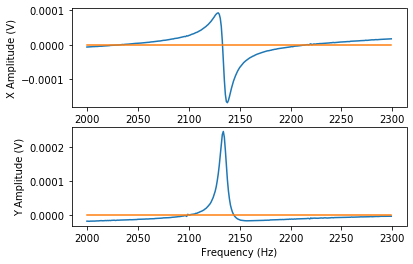

[[inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]]

/---------------------------FIT 2---peakless---------------------------------/
 Peak 1 of 1 at 0.035747608853918145 Hz | FIT Goodness: RSquared =  0.9943557852569259
----------------------------------------------------------
   ABSORPTION AMPLITUDE:  -586.581447266913 V
   ELASTIC AMPLITUDE:     -586.581447266913 V
   RESONANCE AMPLITUDE:   -58561869.33892628 V
   RESONANCE QUALITY:     -1.0449126831844081e-10
   -------------------
   phase shift:           -122.49754510208523 radians
   --------------------
   All other parameters:  [-3.42110967e+08  3.57476089e-02 -1.22497545e+02 -5.85618693e+07]


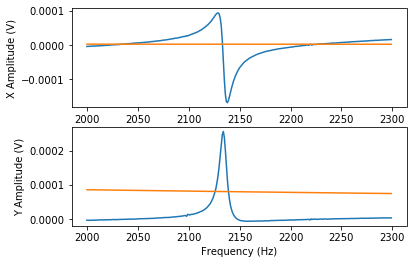

[[inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]]
----------------------------------------------------------------------------//


In [9]:
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy.optimize as opt
import scipy.ndimage as ndi
import statistics as stat
import sys
import tkinter as tk
from tkinter import filedialog
#----------------------------------------------------------
pi = 3.14159265358979323846
wStart = 0 #automatically set
wEnd = 12000
peak_min_width = 30 #required peak width to count as an absorptive peak
STD = 1.4      #required sigma to count as an absorptive peak
PTP = 2        #required peak-to-peak distance (in sigma) to count as an elastic peak
WTH = 0.8 #width multiplier for CI (confidence interval) to completely include peak
σS = 30    #smoothing for initial peak finding def:30
θErr =1.5    #angle offset (max absolute value in radians)
AMax = 1000       #max |amplitude| 
#----------------------------------------------------------
#root = tk.Tk()
#root.withdraw()

#file_path = filedialog.askopenfilename()
#file = open(file_path)
def fileOpen():
    try:
        file = open(input("Filename (no extensions!)")+'.txt')
        print("----------------------------------------------------------")
        return file
    except:
        print("ERROR: Incorrect Filename")
        file = fileOpen()
    if 'file' in locals():
        return file
    else:
        fileOpen()
file = fileOpen()
#----------------------------------------------------------
#DATA STRIP
def dataStrip():
    n = 0
    wStrt,wEn=0,0
    lines = []
    for x in file:  
        ### Ignore first two lines ##
        if n==0:
            ws = x.strip().split("kHz")
            wStrt =int(1000*float(ws[0]))
            wEn =int(1000*float(ws[1][(15):-1]))
            n +=1
        elif n==1:
            n +=1
        else:
            ### Remove '\n' from elements ###
            t = x.strip()
            temp = t.split('\t')
            lines.append(temp)
    #----------------------------------------------------------
    #DATA ARRAY
    wL,rL,xL,yL = [],[],[],[]
    for line in lines:
        wL.append(float(line[0]))
        rL.append(float(line[1]))
        xL.append(float(line[2]))
        yL.append(float(line[3]))
    w,r,x,y=np.array(wL),np.array(rL),np.array(xL),np.array(yL)
    return w,r,x,y,wStrt,wEn
#----------------------------------------------------------
w,r,x,y,wStart,wEnd = dataStrip() #//for some reason this doesn't work in output (wStart and end need to be global?)
#----------------------------------------------------------
#mu, sigma = 0, 0.00001
# creating a noise with the same dimension as the dataset (2,2) 
#noise = np.random.normal(mu, sigma, [len(x)])
#x+=noise
#noise = np.random.normal(mu, sigma, [len(x)])
#y+=noise
#print(noise)
#----------------------------------------------------------
#FIT BKG (LIN) for x,y
def bkg(w_in,m,b):
    return (w_in*m + b)
def smth(x,y):
    x_smth = ndi.gaussian_filter1d(x, σS)
    y_smth = ndi.gaussian_filter1d(y, σS)
    return x_smth,y_smth
#----------------------------------------------------------
#SHIFT x,y (first)
def firstShift(w,x,y):
    x_bkg_p, x_bkg_COV = opt.curve_fit(bkg, w, x)
    x_bkg = bkg(w,x_bkg_p[0],x_bkg_p[1])
    x_shift = x.copy()-x_bkg
    
    y_bkg_p, y_bkg_COV = opt.curve_fit(bkg, w, y)
    y_bkg = bkg(w,y_bkg_p[0],y_bkg_p[1])
    y_shift = y.copy()-y_bkg

    x_smth, y_smth = smth(x_shift,y_shift)
    return x_shift,y_shift,x_smth,y_smth,x_bkg_p,y_bkg_p
#----------------------------------------------------------
#PEAK FINDING (assumes y is arp-like and x is ela-like)
def arp_peaks(w,_smth):
    σ = stat.stdev(_smth)
    TRHLD = STD*σ
    _clean = [0]*len(w)
    for f in range(0,len(w)):
        if((_smth[f]>TRHLD) or (_smth[f]<-TRHLD)):
            _clean[f]=_smth[f]
    _peak_data = []#[[peak_data, final w],[peak,w]..]
    peak_data = []
    collect = False
    for f in range(0,len(w)-1):
        if(collect):
            peak_data.append(_clean[f])
        if(_clean[f]==0 and _clean[f+1]!=0):
            peak_data.clear()
            collect = True
        if(_clean[f]!=0 and _clean[f+1]==0):
            _peak_data.append([f+wStart-len(np.array(peak_data)),f+wStart])
            collect = False
    for peak in _peak_data:
        if(peak[1]-peak[0]<peak_min_width):
            _peak_data.remove(peak)
    return _peak_data
def ela_peaks(_smth,peaks):
    σ = stat.stdev(_smth)
    TRHLD = PTP*σ
    for arppeak in peaks:
        ela_like = _smth[(arppeak[0]-wStart):(arppeak[1]-wStart)]
        _max = max(ela_like)
        _min = min(ela_like)
        if(_max-_min<TRHLD):
            peaks.remove(arppeak)
    return peaks
def peak_filter(w_in,x_smth_in,y_smth_in):
    peaks = []
    for peak in ela_peaks(x_smth_in,arp_peaks(w_in,y_smth_in)):
        d = peak[1]-peak[0]
        sig = (WTH-1)/2
        peaks.append([int(peak[0]-sig*d),int(peak[1]+sig*d)])
    return peaks
def raw_peakless(w_in,x,y,peaks,wStart):
    w_pl = w_in.copy()
    x_pl = x.copy()
    y_pl = y.copy()
    for peak in peaks:
        srt = int(peak[0]-wStart)
        end = int(peak[1]-wStart)
        w1 = w_pl[0:srt]
        w2 = w_pl[end:len(w_pl)]
        x1 = x_pl[0:srt]
        x2 = x_pl[end:len(w_pl)]
        y1 = y_pl[0:srt]
        y2 = y_pl[end:len(w_pl)]
        w_pl = np.hstack([w1,w2])
        x_pl = np.hstack([x1,x2])
        y_pl = np.hstack([y1,y2])
    return w_pl,x_pl,y_pl
#----------------------------------------------------------
#SHIFT x,y (second)
def secondShift(w_in,x,y,peaks,wStart):
    w_pl,x_pl,y_pl = raw_peakless(w_in,x,y,peaks,wStart)
    x_bkg2_p, x_bkg2_COV = opt.curve_fit(bkg, w_pl, x_pl)
    x_bkg2 = bkg(w_in,x_bkg2_p[0],x_bkg2_p[1])
    x_shift2 = x.copy()-x_bkg2
    
    y_bkg2_p, y_bkg2_COV = opt.curve_fit(bkg, w_pl, y_pl)
    y_bkg2 = bkg(w_in,y_bkg2_p[0],y_bkg2_p[1])
    y_shift2 = y.copy()-y_bkg2
    return x_shift2,y_shift2,x_bkg2_p,y_bkg2_p
#----------------------------------------------------------
#DEF FITS x,y
# λ is damping parameter, w0 is resonance frequency, θ is phase shift
# y = A cos θ - B sin θ
# x = A sin θ + B cos θ
def ela(w_in, λ, w0, A, sgn):#elastic (note w is not really f! so lambda needs to be divided by 2pi!)
    return sgn*A*(pow(w0,2) - pow(w_in,2))/(pow((pow(w0,2) - pow(w_in,2)),2) + pow(λ*w_in,2))
def arp(w_in, λ, w0, A, sgn):#absorptive
    return sgn*A*λ*w_in/(pow((pow(w0,2) - pow(w_in,2)),2) + pow(λ*w_in,2)) 
def y_fit(w_in, λ, w0, θ, A, sgn):#arp-like
    return arp(w_in,λ,w0,A,sgn)*math.cos(θ)-ela(w_in,λ,w0,A,sgn)*math.sin(θ)
def x_fit(w_in, λ, w0, θ, A, sgn):#ela-like
    return arp(w_in,λ,w0,A,sgn)*math.sin(θ)+ela(w_in,λ,w0,A,sgn)*math.cos(θ)
def y_fitB(w_in, λ, w0, θ, A, sgn,my,by):#arp-like
    return arp(w_in,λ,w0,A,sgn)*math.cos(θ)-ela(w_in,λ,w0,A,sgn)*math.sin(θ)+bkg(w_in,my,by)
def x_fitB(w_in, λ, w0, θ, A, sgn,mx,bx):#ela-like
    return arp(w_in,λ,w0,A,sgn)*math.sin(θ)+ela(w_in,λ,w0,A,sgn)*math.cos(θ)+bkg(w_in,mx,bx)
#stack fits
def posfitStack(w_in, λ, w0, θ, A):
    return np.hstack([x_fit(w_in,λ,w0,θ,A,1),y_fit(w_in,λ,w0,θ,A,1)])
def negfitStack(w_in, λ, w0, θ, A):
    return np.hstack([x_fit(w_in,λ,w0,θ,A,-1),y_fit(w_in,λ,w0,θ,A,-1)])
#stack fits
def posfitStackB(w_in, λ, w0, θ, A,mx,bx,my,by):
    return np.hstack([x_fitB(w_in,λ,w0,θ,A,1,mx,bx),y_fitB(w_in,λ,w0,θ,A,1,my,by)])
def negfitStackB(w_in, λ, w0, θ, A,mx,bx,my,by):
    return np.hstack([x_fitB(w_in,λ,w0,θ,A,-1,mx,bx),y_fitB(w_in,λ,w0,θ,A,-1,my,by)])
#stack data
def dataStack(w_in,x_shift2,y_shift2,wStart):
    srt = int(w_in[0])
    end = int(w_in[len(w_in)-1]+1)
    return np.hstack([(x_shift2[srt-wStart:end-wStart]), (y_shift2[srt-wStart:end-wStart])])
def Rsquare(obs,exp):
    sig = stat.stdev(exp)
    return 1-(np.sum((obs-exp)**2)/sig)
#----------------------------------------------------------
#FIT elastic and absorptive  #,bounds=([0,0,-θErr,-AMax], [1000, wEnd, θErr, AMax]))
def fitPeak(w_in,x_shift2,y_shift2,in_peaks, i, wStart,y_smth):
    wPeak = w_in[(in_peaks[i][0]-wStart):(in_peaks[i][1]-wStart)]
    #Guesses
    λguess = 100
    θguess = 0.5
    wGuess = (w_in[(in_peaks[i][0]-wStart)]+w_in[(in_peaks[i][1]-wStart)])/2
    amp_guess = y_smth[(in_peaks[i][0]-wStart)]
    p0 =[λguess,wGuess,θguess,amp_guess]
    #bounds=([50,4000,0.0001,0], [200, 12000, 1,10])
    #-------
    if(amp_guess<0): #y_smth[(_peaks[i][0]-wStart)]
        fit_p, fit_COV = opt.curve_fit(posfitStack, wPeak, dataStack(wPeak,x_shift2,y_shift2,wStart),maxfev=10000)
        sgn=1
    else:
        fit_p, fit_COV = opt.curve_fit(negfitStack, wPeak, dataStack(wPeak,x_shift2,y_shift2,wStart),maxfev=10000)
        sgn=-1
    fit_p[1]=np.abs(fit_p[1])
    if(fit_p[0]<0):
        print("ERROR - DAMPING NEGATIVE: Fitting has failed to produce realistic results")
        #sys.exit()
    x_fitline = x_fit(w_in,fit_p[0],fit_p[1],fit_p[2],fit_p[3],sgn)
    y_fitline = y_fit(w_in,fit_p[0],fit_p[1],fit_p[2],fit_p[3],sgn)
    Rsquared = Rsquare(dataStack(wPeak,x_fitline,y_fitline,wStart),dataStack(wPeak,x_shift2,y_shift2,wStart))
    return x_fitline,y_fitline,fit_p,fit_COV,Rsquared
#FIT elastic and absorptive  #,bounds=([0,0,-θErr,-AMax], [1000, wEnd, θErr, AMax]))
def fitPeakT(w_in,x_,y_,in_peaks, i, wStart,y_smth,x_bkg_p,y_bkg_p):
    wPeak = w_in[(in_peaks[i][0]-wStart):(in_peaks[i][1]-wStart)]
    #Guesses
    λguess = 100
    θguess = 0.5
    wGuess = (w_in[(in_peaks[i][0]-wStart)]+w_in[(in_peaks[i][1]-wStart)])/2
    amp_guess = y_smth[(in_peaks[i][0]-wStart)]
    p0 =[λguess,wGuess,θguess,amp_guess,x_bkg_p[0],x_bkg_p[1],y_bkg_p[0],y_bkg_p[1]]
    print(p0)
    bounds=([50,4000,-1,-10,-1,-1,-1,-1], [200,12000,1,10,1,1,1,1])
    #-------
    if(amp_guess<0): #y_smth[(_peaks[i][0]-wStart)]
        fit_p, fit_COV = opt.curve_fit(posfitStackB, wPeak, dataStack(wPeak,x_,y_,wStart),p0=p0,bounds=bounds,maxfev=100000)
        sgn=1
    else:
        fit_p, fit_COV = opt.curve_fit(negfitStackB, wPeak, dataStack(wPeak,x_,y_,wStart),p0=p0,bounds=bounds,maxfev=100000)
        sgn=-1
    fit_p[1]=np.abs(fit_p[1])
    if(fit_p[0]<0):
        print("ERROR - DAMPING NEGATIVE: Fitting has failed to produce realistic results")
        #sys.exit()
    x_fitline = x_fitB(w_in,fit_p[0],fit_p[1],fit_p[2],fit_p[3],fit_p[4],fit_p[5],sgn)
    y_fitline = y_fitB(w_in,fit_p[0],fit_p[1],fit_p[2],fit_p[3],fit_p[6],fit_p[7],sgn)
    Rsquared = Rsquare(dataStack(wPeak,x_fitline,y_fitline,wStart),dataStack(wPeak,x_,y_,wStart))
    return x_fitline,y_fitline,fit_p,fit_COV,Rsquared
#----------------------------------------------------------
def outVal(fit_p,n,t,rsquared):
    print(" Peak",(n+1),"of",t,"at",fit_p[1],"Hz | FIT Goodness: RSquared = ",rsquared)
    print("----------------------------------------------------------")
    print("   ABSORPTION AMPLITUDE: ",arp(fit_p[1],fit_p[0],fit_p[1],fit_p[2],fit_p[3]),"V")
    print("   ELASTIC AMPLITUDE:    ",arp(fit_p[1],fit_p[0],fit_p[1],fit_p[2],fit_p[3]),"V")
    #print("   -------------------")
    print("   RESONANCE AMPLITUDE:  ",fit_p[3],"V")
    print("   RESONANCE QUALITY:    ",(fit_p[1]/fit_p[0]))
    print("   -------------------")
    print("   phase shift:          ",(fit_p[2]), "radians")
    print("   --------------------")
    print("   All other parameters: ",fit_p)
    return
def plot(w_in,x_fitline,y_fitline,x_shifted,y_shifted):
    fig, axs = plt.subplots(2)
    axs[0].plot(w_in,x_shifted)
    axs[0].plot(w_in,x_fitline)
    axs[0].set_xlabel("Frequency (Hz)")
    axs[0].set_ylabel("X Amplitude (V)")
    axs[1].plot(w_in,y_shifted)
    axs[1].plot(w_in,y_fitline)
    axs[1].set_xlabel("Frequency (Hz)")
    axs[1].set_ylabel("Y Amplitude (V)")
    plt.show()
    return
#----------------------------------------------------------
def outputResonances(w_in,x,y,x_shift,y_shift,x_shift2,y_shift2,_peaks, iteration,wStart,y_smth,x_bkg_p,y_bkg_p):
    t = len(_peaks)
    for n in range(0,t):
        rsquared,rsquared2,rsquared3 = 0,0,0;
        try:
            x_fitline,y_fitline,fit_p,COV_MX,rsquared = fitPeak(w_in,x_shift,y_shift,_peaks,n,wStart,y_smth)
        except BaseException as e:
            print("ERROR: Fitting with average linear background has failed to converge")
            print("\t",e)
        try:
            x_fitline2,y_fitline2,fit_p2,COV_MX2,rsquared2 = fitPeak(w_in,x_shift2,y_shift2,_peaks,n,wStart,y_smth)
        except BaseException as e:
            print("ERROR: Fitting with peakless linear background has failed to converge")
            print("\t",e)
        try:
            x_fitline3,y_fitline3,fit_p3,COV_MX3,rsquared3 = fitPeakT(w_in,x,y,_peaks,n,wStart,y_smth,x_bkg_p,y_bkg_p)
        except BaseException as e:
            print("ERROR: Fitting together with linear background has failed to converge")
            print("\t",e)
        if(rsquared==0 and rsquared2==0 and rsquared3==0):
            print("ERROR: All fits failed to converge.")
            if(iteration<2):
                retry = input("Do you wish to try with a smoother version? Y/N:")
                if(retry==("Y")):
                    print("Retrying...")
                    print("UNFIT data:")
                    x_shift_sm,y_shift_sm = smth(x_shift,y_shift)
                    x_shift_sm2,y_shift_sm2 = smth(x_shift2,y_shift2)
                    plt.plot(w,x_shift_sm2)
                    plt.plot(w,y_shift_sm2)
                    plt.show()
                    outputResonances(w_in,x,y,x_shift_sm,y_shift_sm,x_shift_sm2,y_shift_sm2,_peaks, (iteration+1),wStart,y_shift_sm,x_bkg_p,y_bkg_p)
                return
        else:
            if(rsquared!=0):
                print("\n/---------------------------FIT 1---average----------------------------------/")
                outVal(fit_p,n,t,rsquared)
                plot(w_in,x_fitline,y_fitline,x_shift,y_shift)
                print(COV_MX)
            if(rsquared2!=0):
                print("\n/---------------------------FIT 2---peakless---------------------------------/")
                outVal(fit_p2,n,t,rsquared2)
                plot(w_in,x_fitline2,y_fitline2,x_shift2,y_shift2)
                print(COV_MX2)
            if(rsquared3!=0):
                print("\n/---------------------------FIT 3---together---------------------------------/")
                outVal(fit_p3,n,t,rsquared3)
                plot(w_in,x_fitline3,y_fitline3,x,y)
                print(COV_MX3)
        print("----------------------------------------------------------------------------//")
    return
def output(w,x,y,wStart):
    x_shift,y_shift,x_smth,y_smth,x_bkg_p,y_bkg_p = firstShift(w,x,y)
    print("First Background Parameters: [Mx Bx] [My By] = ",x_bkg_p,y_bkg_p)
    _peaks = peak_filter(w,x_smth,y_smth)
    x_shift2,y_shift2,x_bkg_p,y_bkg_p = secondShift(w,x,y,_peaks,wStart)
    print("Second Background Parameters: [Mx Bx] [My By] = ",x_bkg_p,y_bkg_p)
    print("----------------------------------------------------------------------------//")
    print("Resonances Found: ",len(_peaks))
    print("UNFIT data:")
    plt.plot(w,x_shift2)
    plt.plot(w,y_shift2)
    for peak in _peaks:
        plt.axvspan(peak[0], peak[1], color='red', alpha=0.1)
    plt.show()
    print("----------------------------------------------------------------------------//")
    if(len(_peaks)<1):
        retry = input("Do you wish to try with a smoother version? Y/N:")
        if(retry==("Y")):
            print("Retrying...")
            x_s,y_s = smth(x,y)
            output(w,x_s,y_s,wStart)
        return
    outputResonances(w,x,y,x_shift,y_shift,x_shift2,y_shift2,_peaks,0,wStart,y_smth,x_bkg_p,y_bkg_p)
    return
#----------------------------------------------------------
output(w,x,y,wStart)